In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import pathlib

import sys
sys.path.append("..")  # Adiciona a pasta anterior ao path
import micromag as mg

In [2]:
fig_dir = pathlib.Path("../..") / "paper" / "figures"

In [3]:
def angular_distance(vec_a, vec_b):
    # Produto escalar entre os vetores
    dot_product = np.dot(vec_a, vec_b)
    
    # Magnitudes dos vetores
    magnitude_a = np.linalg.norm(vec_a)
    magnitude_b = np.linalg.norm(vec_b)
    
    # Cálculo do cosseno do ângulo
    cos_theta = dot_product / (magnitude_a * magnitude_b)
    
    # Ângulo em radianos
    theta = np.rad2deg(np.arccos(cos_theta))
    # theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))# Clipping para evitar erros numéricos
    return theta



In [4]:
r2 =  0.9

In [5]:
# Pasta onde os arquivos CSV estão localizados
csv_folder = "csv_files_real_data"
# Listas para armazenar os momentos dipolares
mx_all_standard, my_all_standard, mz_all_standard = [], [], []
mx_all_iterative, my_all_iterative, mz_all_iterative = [], [], []

# Listas para armazenar os valores de R²
r2_all_standard, r2_all_iterative = [], []

# Get windows
areas_standard = []
areas_iterative = []

 
# Processar os arquivos da pasta
for file in os.listdir(csv_folder):
    if file.endswith("_standard.csv"):
        # Ler os arquivos padrão
        df_standard = pd.read_csv(os.path.join(csv_folder, file))
        mx_all_standard.extend(df_standard['mx_standard'].values)
        my_all_standard.extend(df_standard['my_standard'].values)
        mz_all_standard.extend(df_standard['mz_standard'].values)
        r2_all_standard.extend(df_standard['r_2_standard'].values)
        
        areas_standard.extend(
             (df_standard['xmax'].values - df_standard['xmin'].values) * 
             (df_standard['ymax'].values - df_standard['ymin'].values) 
             # *abs(df_standard['zc_standard'].values)
            )

    elif file.endswith("_iterative.csv"):
        # Ler os arquivos iterativos
        df_iterative = pd.read_csv(os.path.join(csv_folder, file))
        mx_all_iterative.extend(df_iterative['mx_iterative'].values)
        my_all_iterative.extend(df_iterative['my_iterative'].values)
        mz_all_iterative.extend(df_iterative['mz_iterative'].values)
        r2_all_iterative.extend(df_iterative['r_2_iterative'].values)

        areas_iterative.extend(
             (df_iterative['xmax'].values - df_iterative['xmin'].values) * 
             (df_iterative['ymax'].values - df_iterative['ymin'].values) 
             # *abs(df_iterative['zc_iterative'].values)
            )


# Criar as listas com as soluções finais para os momentos dipolares
dipole_moment_standard = np.array([
    np.array(mx_all_standard), 
    np.array(my_all_standard), 
    np.array(mz_all_standard)
]).T

dipole_moment_iterative = np.array([
    np.array(mx_all_iterative), 
    np.array(my_all_iterative), 
    np.array(mz_all_iterative)
]).T

# Criar arrays para os valores de R²
r2_standard = np.array(r2_all_standard)
r2_iterative = np.array(r2_all_iterative)

areas_standard = np.array(areas_standard)*mg.MICROMETER_TO_METER
areas_iterative = np.array(areas_iterative)*mg.MICROMETER_TO_METER


In [6]:
dipole_moment_standard = dipole_moment_standard[r2_standard >= r2]
dipole_moment_iterative = dipole_moment_iterative[r2_iterative >= r2]


areas_standard = areas_standard[r2_standard >= r2]
areas_iterative = areas_iterative[r2_iterative >= r2]

r2_standard = r2_standard[r2_standard >= r2]
r2_iterative = r2_iterative[r2_iterative >= r2]

In [7]:
# dipole_moment_standard = dipole_moment_standard / areas_standard[:, np.newaxis]
# dipole_moment_iterative = dipole_moment_iterative / areas_iterative[:, np.newaxis]

In [8]:
norm_standard = np.linalg.norm(dipole_moment_standard, axis=1)
norm_iterative = np.linalg.norm(dipole_moment_iterative, axis=1)

# norm_standard

In [9]:
indices_standard = np.argsort(norm_standard)[::-1]
indices_iterative = np.argsort(norm_iterative)[::-1]

norm_iterative[indices_iterative]
norm_standard[indices_standard]

array([3.06793835e-11, 2.95994847e-11, 2.83630621e-11, ...,
       5.00997138e-14, 4.23201488e-14, 3.04628541e-14])

In [10]:
dipole_moment_standard = dipole_moment_standard[indices_standard]
dipole_moment_iterative = dipole_moment_iterative[indices_iterative]
r2_standard = r2_standard[indices_standard]
r2_iterative = r2_iterative[indices_iterative]

In [11]:
# Defina sua direção de referência (por exemplo, vetor unitário)
inc_ref, dec_ref = 47, 155
reference_vector = mg.angles_to_vector(inc_ref, dec_ref, 1)  # exemplo, ajuste conforme necessário

angular_distance_standard = []
angular_distance_iterative = []
vector_sum_standard, vector_sum_iterative = [], []
inc_standard, dec_standard = [], []
inc_iterative, dec_iterative = [], []
# Calculando a distância angular para a metodologia "standard"
for n in range(2, len(dipole_moment_standard[:, 0])+1):
    vector_sum_st = np.sum(dipole_moment_standard[:n, :], axis=0, dtype=np.float64)
    inc_st, dec_st, _ = mg.vector_to_angles(vector_sum_st)
    vector_sum_standard.append(vector_sum_st)
    inc_standard.append(inc_st)
    dec_standard.append(dec_st)
    # Calcula a distância angular
    # angular_distance_value=angle_misfit(inc_ref, dec_ref, inc, dec)
    angular_distance_value_st = angular_distance(reference_vector, vector_sum_st)
    angular_distance_standard.append(angular_distance_value_st)

# Calculando a distância angular para a metodologia "iterative"
for n in range(2, len(dipole_moment_iterative[:, 0])+1):
    vector_sum_it = np.sum(dipole_moment_iterative[:n, :], axis=0, dtype=np.float64)
    inc_it, dec_it, _ = mg.vector_to_angles(vector_sum_it)
    vector_sum_iterative.append(vector_sum_it)
    inc_iterative.append(inc_it)
    dec_iterative.append(dec_it)
    # Calcula a distância angular
    angular_distance_value_it = angular_distance(reference_vector, vector_sum_it)
    # angular_distance_value=angle_misfit(inc_ref, dec_ref, inc, dec)
    angular_distance_iterative.append(angular_distance_value_it)


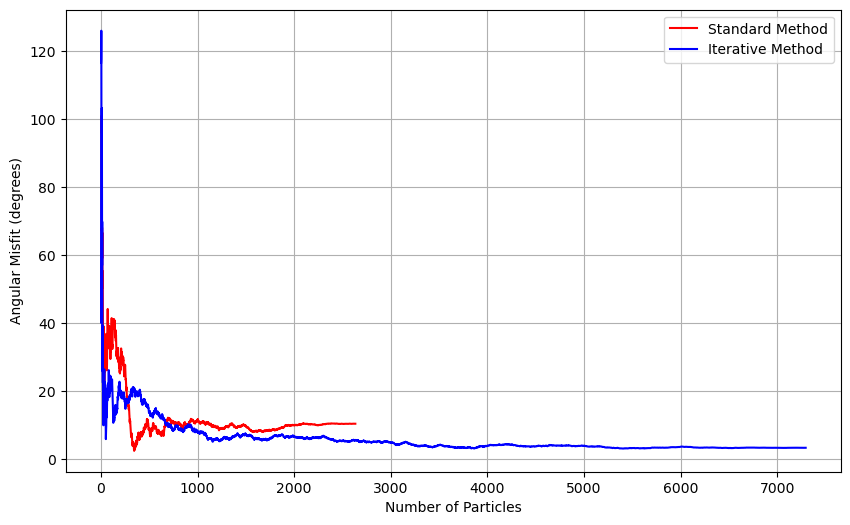

In [12]:
# Número de partículas é equivalente a 'n' nos loops, então você pode usar o range de 'n' para o eixo x
num_particles_standard = list(range(2, len(dipole_moment_standard[:, 0])+1))
num_particles_iterative = list(range(2, len(dipole_moment_iterative[:, 0])+1))

# Plotando as distâncias angulares
plt.figure(figsize=(10, 6))

# Plot para a metodologia "standard"
plt.plot(num_particles_standard, angular_distance_standard, label='Standard Method', c='r')

# Plot para a metodologia "iterative"
plt.plot(num_particles_iterative, angular_distance_iterative, label='Iterative Method', c='b')

# Adicionando rótulos e título
plt.xlabel('Number of Particles')
plt.ylabel('Angular Misfit (degrees)')
# plt.title('Angular Distance vs Number of Particles')
plt.legend()

# Exibindo o gráfico
plt.grid(True)
plt.show()


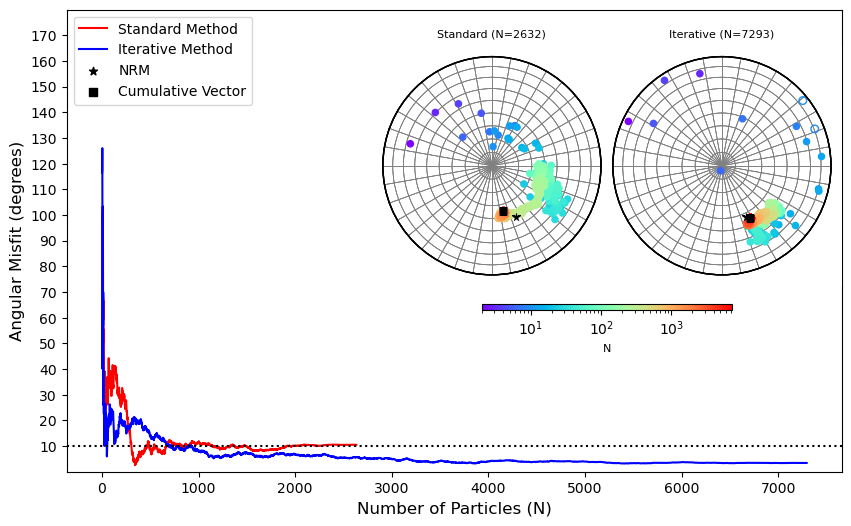

In [13]:
# Número de partículas é equivalente a 'n' nos loops, então você pode usar o range de 'n' para o eixo x
num_particles_standard = list(range(2, len(dipole_moment_standard[:, 0])+1))
num_particles_iterative = list(range(2, len(dipole_moment_iterative[:, 0])+1))

# Criar a figura principal
fig, ax = plt.subplots(figsize=(10, 6))

# Plotando as distâncias angulares
ax.plot(num_particles_standard, angular_distance_standard, label='Standard Method', c='r')
ax.plot(num_particles_iterative, angular_distance_iterative, label='Iterative Method', c='b')
ax.set_xlabel('Number of Particles (N)', fontsize=12)
ax.set_ylabel('Angular Misfit (degrees)', fontsize=12)
ax.scatter([],[], marker='*',label='NRM', c='k')
ax.scatter([],[], marker='s',label='Cumulative Vector', c='k')
ax.axhline(y=10, xmin=2/5000, xmax=1, color='k', ls='dotted')
ax.legend(loc='upper left')


# Definindo áreas para as projeções estereográficas dentro do gráfico principal
# Definindo a posição das projeções dentro do gráfico com (x0, y0, width, height)
projection_positions = [
    (0.3, 0.32, 0.4, 0.4),  # Posição do gráfico de projeção padrão
    (0.55, 0.32, 0.4, 0.4)   # Posição do gráfico de projeção iterativo
]

projection_positions = [
    (0.35, 0.42, 0.4, 0.4),  # Posição do gráfico de projeção padrão
    (0.58, 0.42, 0.4, 0.4)   # Posição do gráfico de projeção iterativo
]


# Títulos e dados para os subgráficos
titles = [
    "Standard",
    "Iterative"
]

sum_st = vector_sum_standard[-1]
sum_it = vector_sum_iterative[-1]

datasets = [
    (inc_standard, dec_standard, vector_sum_standard, sum_st),
    (inc_iterative, dec_iterative, vector_sum_iterative, sum_it)
]


cmap = "rainbow"  # Escolha um colormap
maximum = np.max([len(inc_standard), len(inc_iterative)])
cmap_norm = matplotlib.colors.LogNorm #Normalize
# Plotando as projeções estereográficas nas posições definidas
for pos, (title, (inc, dec, vector_sum, sum_vector)) in zip(projection_positions, zip(titles, datasets)):
    # Calcular novo amplitude
    new_amp = range(2, len(inc) + 2)
    
    # Recalcular o vetor somado com nova amplitude
    new_vector_sum = mg.angles_to_vector(inc, dec, new_amp)
    
    # Criar a projeção estereográfica
    projection = mg.StereographicProjection(new_vector_sum)
    projection_R = mg.StereographicProjection(np.reshape(reference_vector,(1,3))) 
    projection_J = mg.StereographicProjection(np.reshape(sum_vector,(1,3))) 
    # Adicionar a área para o gráfico de projeção estereográfica
    inset_ax = fig.add_axes(pos)
    # Configurar kwargs para o scatter plot
    kwargs = dict(s=30, cmap=cmap, vmin=2, vmax=maximum, cmap_norm=cmap_norm)
    
    # Plotar a projeção estereográfica no inset
    tmp = projection.plot(ax=inset_ax, add_ticks=False,  **kwargs)
    tmp_R = projection_R.plot(ax=inset_ax, add_ticks=False, s=50, marker='*')
    tmp_J = projection_J.plot(ax=inset_ax, add_ticks=False, s=30, marker='s')
    
    # Adicionar a quantidade de fontes no título
    num_sources = len(inc)
    inset_ax.set_title(f"{title} (N={num_sources})", fontsize=8)
# Configuração da barra de cores compartilhada
clb = fig.colorbar(
    tmp,
    ax=ax,
    # cax=fig.add_axes([0.5, 0.3, 0.25, 0.01]),
    cax=fig.add_axes([0.54, 0.38, 0.25, 0.01]),
    # format="%.0g",
    orientation="horizontal",
)
clb.set_label(label="N", fontsize=8)
clb.ax.tick_params(labelsize=10)

ax.set_yticks(np.arange(10,180,10))
ax.set_ylim(0,180)
# plt.tight_layout()  # Ajusta o layout automaticamente
# ax.grid(True)
# fig.savefig(fig_dir / "basalt-data-stereoplot.png", dpi=300, facecolor='w', bbox_inches='tight')
plt.show()


# Filtering by amplitude

In [14]:
def remove_outliers(moments):
    # Calculate the norm of each dipole vector
    norm_values = np.linalg.norm(moments, axis=1)

    # Apply log10 to the norm values to adjust for orders of magnitude
    log_norm_values = np.log10(norm_values)

    # Calculate Q1 (first quartile) and Q3 (third quartile) in the logarithmic scale
    Q1 = np.percentile(log_norm_values, 25)
    Q3 = np.percentile(log_norm_values, 75)

    # Calculate the IQR (Interquartile Range) in the logarithmic scale
    IQR = Q3 - Q1

    # Determine the upper and lower bounds for outliers in the logarithmic scale
    # lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    outliers_filtered = moments[(log_norm_values <= upper_bound)]
    
    return outliers_filtered

In [15]:
dipole_moment_standard_filtered  = remove_outliers(dipole_moment_standard)
dipole_moment_iterative_filtered = remove_outliers(dipole_moment_iterative)

In [16]:
angular_distance_standard_filtered = []
angular_distance_iterative_filtered = []
vector_sum_standard_filtered, vector_sum_iterative_filtered = [], []
inc_standard_filtered, dec_standard_filtered = [], []
inc_iterative_filtered, dec_iterative_filtered = [], []
# Calculando a distância angular para a metodologia "standard"
for n in range(2, len(dipole_moment_standard_filtered[:, 0])):
    vector_sum = np.sum(dipole_moment_standard_filtered[:n, :], axis=0)
    inc, dec, _ = mg.vector_to_angles(vector_sum)
    vector_sum_standard_filtered.append(vector_sum)
    inc_standard_filtered.append(inc)
    dec_standard_filtered.append(dec)
    # Calcula a distância angular
    angular_distance_value = angular_distance(reference_vector, vector_sum)
    angular_distance_standard_filtered.append(angular_distance_value)

# Calculando a distância angular para a metodologia "iterative"
for n in range(2, len(dipole_moment_iterative_filtered[:, 0])):
    vector_sum = np.sum(dipole_moment_iterative_filtered[:n, :], axis=0)
    inc, dec, _ = mg.vector_to_angles(vector_sum)
    vector_sum_iterative_filtered.append(vector_sum)
    inc_iterative_filtered.append(inc)
    dec_iterative_filtered.append(dec)

    # Calcula a distância angular
    angular_distance_value = angular_distance(reference_vector, vector_sum)
    angular_distance_iterative_filtered.append(angular_distance_value)


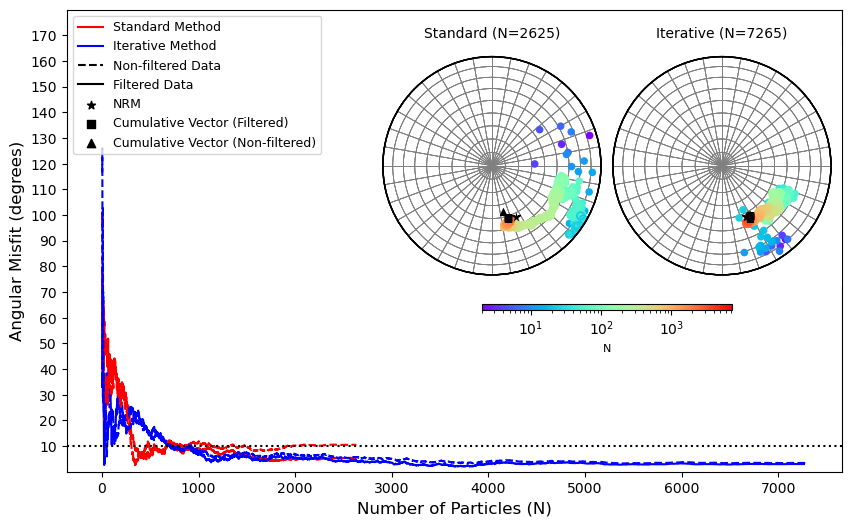

In [24]:
# Número de partículas é equivalente a 'n' nos loops, então você pode usar o range de 'n' para o eixo x
num_particles_standard_filtered = list(range(2, len(dipole_moment_standard_filtered[:, 0])))
num_particles_iterative_filtered = list(range(2, len(dipole_moment_iterative_filtered[:, 0])))

# Criar a figura principal
fig, ax = plt.subplots(figsize=(10, 6))

# Plotando as distâncias angulares

ax.plot(num_particles_standard_filtered, angular_distance_standard_filtered, 
        label='Standard Method', c='r')
ax.plot(num_particles_iterative_filtered, angular_distance_iterative_filtered, 
        label='Iterative Method', c='b')
ax.plot(num_particles_standard, angular_distance_standard, 
        c='r', ls='dashed')
ax.plot(num_particles_iterative, angular_distance_iterative, 
        c='b', ls='dashed')
ax.plot([], [], c='k', ls='dashed', label='Non-filtered Data')  
ax.plot([], [], c='k', label='Filtered Data')  
ax.set_xlabel('Number of Particles (N)', fontsize=12)
ax.set_ylabel('Angular Misfit (degrees)', fontsize=12)
ax.scatter([], [], marker='*', label='NRM', edgecolors='k', facecolors='k')
ax.scatter([], [], marker='s', label='Cumulative Vector (Filtered)', edgecolors='k', facecolors='k')
ax.scatter([], [], marker='^', label='Cumulative Vector (Non-filtered)', edgecolors='k', facecolors='k')
ax.axhline(y=10, xmin=2/5000, xmax=1, color='k', ls='dotted')
ax.legend(loc='upper left', fontsize=9)


# Definindo áreas para as projeções estereográficas dentro do gráfico principal
# Definindo a posição das projeções dentro do gráfico com (x0, y0, width, height)
projection_positions = [
    (0.3, 0.32, 0.4, 0.4),  # Posição do gráfico de projeção padrão
    (0.55, 0.32, 0.4, 0.4)   # Posição do gráfico de projeção iterativo
]

projection_positions = [
    (0.35, 0.42, 0.4, 0.4),  # Posição do gráfico de projeção padrão
    (0.58, 0.42, 0.4, 0.4)   # Posição do gráfico de projeção iterativo
]


# Títulos e dados para os subgráficos
titles = [
    "Standard",
    "Iterative"
]

sum_st_filtered = vector_sum_standard_filtered[-1]
sum_it_filtered = vector_sum_iterative_filtered[-1]

datasets = [
    (inc_standard_filtered, dec_standard_filtered, vector_sum_standard_filtered, sum_st_filtered, sum_st),
    (inc_iterative_filtered, dec_iterative_filtered, vector_sum_iterative_filtered, sum_it_filtered, sum_it)
]


cmap = "rainbow"  # Escolha um colormap
maximum = np.max([len(inc_standard), len(inc_iterative)])
cmap_norm = matplotlib.colors.LogNorm #Normalize
# Plotando as projeções estereográficas nas posições definidas
for pos, (title, (inc, dec, vector_sum, sum_vector_filtered, sum_vector)) in zip(projection_positions, zip(titles, datasets)):
    # Calcular novo amplitude
    new_amp = range(2, len(inc) + 2)
    
    # Recalcular o vetor somado com nova amplitude
    new_vector_sum = mg.angles_to_vector(inc, dec, new_amp)
    
    # Criar a projeção estereográfica
    projection = mg.StereographicProjection(new_vector_sum)
    projection_R = mg.StereographicProjection(np.reshape(reference_vector,(1,3))) 
    projection_S_filtered = mg.StereographicProjection(np.reshape(sum_vector_filtered,(1,3)))
    projection_S = mg.StereographicProjection(np.reshape(sum_vector,(1,3)))
    # Adicionar a área para o gráfico de projeção estereográfica
    inset_ax = fig.add_axes(pos)
    # Configurar kwargs para o scatter plot
    kwargs = dict(s=30, cmap=cmap, vmin=2, vmax=maximum, cmap_norm=cmap_norm)
    
    # Plotar a projeção estereográfica no inset
    tmp = projection.plot(ax=inset_ax, add_ticks=False,  **kwargs)
    tmp_R = projection_R.plot(ax=inset_ax, add_ticks=False, s=50, marker='*')
    tmp_S = projection_S.plot(ax=inset_ax, add_ticks=False, s=30, marker='^')
    tmp_S = projection_S_filtered.plot(ax=inset_ax, add_ticks=False, s=30, marker='s')
    
    # Adicionar a quantidade de fontes no título
    num_sources = len(inc)
    inset_ax.set_title(f"{title} (N={num_sources})", fontsize=10)
# Configuração da barra de cores compartilhada
clb = fig.colorbar(
    tmp,
    ax=ax,
    # cax=fig.add_axes([0.5, 0.3, 0.25, 0.01]),
    cax=fig.add_axes([0.54, 0.38, 0.25, 0.01]),
    # format="%.0g",
    orientation="horizontal",
)
clb.set_label(label="N", fontsize=8)
clb.ax.tick_params(labelsize=10)

ax.set_yticks(np.arange(10,180,10))
ax.set_ylim(0,180)
fig.savefig(fig_dir / "basalt-data-stereoplot.png", dpi=300, facecolor='w', bbox_inches='tight')
plt.show()


In [19]:
print('Results before the amplitude filter')
print(f"Final angular misfit for the standard method:  {np.round(angular_distance_standard[-1], 2)}°")
print(f"Final angular misfit for the iterative method: {np.round(angular_distance_iterative[-1],2)}°")
print()
print('Results after the amplitude filter')
print(f"Final angular misfit for the standard method:  {np.round(angular_distance_standard_filtered[-1], 2)}°")
print(f"Final angular misfit for the iterative method: {np.round(angular_distance_iterative_filtered[-1],2)}°")

Results before the amplitude filter
Final angular misfit for the standard method:  10.49°
Final angular misfit for the iterative method: 3.42°

Results after the amplitude filter
Final angular misfit for the standard method:  5.41°
Final angular misfit for the iterative method: 2.98°
